#### Example of text classification with word2vec embeddings generated from the target corpus (Consumer Finance Complaints dataset).

Reference pages:
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
- https://sturzamihai.com/how-to-use-pre-trained-word-vectors-with-keras/
- https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
- https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [30]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


In [31]:
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


Text preprocessing

In [32]:
%%time
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# tokenizing, removing punctuation and converting to lower case
tokenizer = RegexpTokenizer(r'\w+')
text = text.apply(lambda x: tokenizer.tokenize(x.lower()))

# stop words removal
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words
text = text.apply(lambda x: remove_stopwords(x))

text.head()

CPU times: user 1min 50s, sys: 9.52 s, total: 1min 59s
Wall time: 2min


0                               [mine, please, remove]
1    [transunion, incorrectly, reporting, authorize...
2    [disputing, derogatory, mark, credit, report, ...
3    [sent, letters, credit, bureau, equifax, negat...
4    [ive, working, back, forth, calling, emailing,...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in sss.split(text, df['category_id']):
    train_set = text.loc[train_index]
    train_labels = df['category_id'].loc[train_index]
    test_set = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]

Creating word embeddings.

Word2vec parameters:
- `size=n` - The dimension that the Word2Vec vectors will have.
- `min_count=n` - Include the word in our vocabulary after n encounters.
- `iter=n` - In how many epochs should the Word2Vec model learn the semantic correlations.

In [19]:
%%time
import gensim

word_model = gensim.models.Word2Vec(train_set, size=300, min_count=2, iter=10)

CPU times: user 13.6 s, sys: 70.7 ms, total: 13.7 s
Wall time: 6.39 s


In [20]:
word_model.wv.most_similar(positive='quality')

[('deep', 0.9879833459854126),
 ('flags', 0.9834755659103394),
 ('merger', 0.9830029606819153),
 ('obstructing', 0.982875406742096),
 ('borderline', 0.9826929569244385),
 ('fixtures', 0.9822198748588562),
 ('sharing', 0.9816129803657532),
 ('race', 0.9811797142028809),
 ('assisting', 0.9808827638626099),
 ('challenged', 0.9796955585479736)]

Each document must be converted to a vector. So, we'll use the mean vector of its words.

In [21]:
import numpy as np

def word_averaging(model, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in model.wv.vocab:
            mean.append(model.wv.vectors_norm[model.wv.vocab[word].index])
            all_words.add(model.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(model.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(model, text_list):
    return np.vstack([word_averaging(model, review) for review in text_list ])

In [22]:
%%time
X_train_word_average = word_averaging_list(word_model, train_set)
X_test_word_average = word_averaging_list(word_model, test_set)

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.12 s


Let's train and evaluate some classifiers.

In [23]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=0),
    svm.LinearSVC(random_state=0),
    MLPClassifier(max_iter=1000, random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_word_average, train_labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 1min 58s, sys: 1.1 s, total: 1min 59s
Wall time: 1min 6s


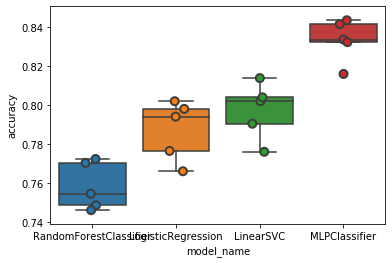

In [24]:
%matplotlib inline
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [25]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.797244
LogisticRegression        0.787301
MLPClassifier             0.833429
RandomForestClassifier    0.758307
Name: accuracy, dtype: float64

Best model evaluation

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.830398517145505
confusion matrix
 [[172  26  12   5   1]
 [ 22 178   6   6   4]
 [ 19  13 162   3  19]
 [  4   5   4 200   3]
 [  3   3  18   7 184]]
(row=expected, col=predicted)
CPU times: user 37.1 s, sys: 515 ms, total: 37.6 s
Wall time: 18.9 s


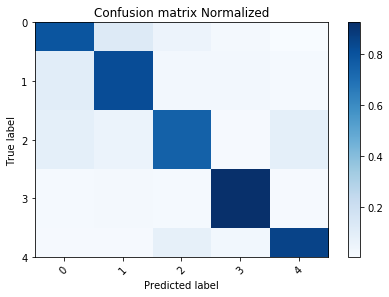

In [28]:
%%time
model = models[3]
model.fit(X_train_word_average, train_labels)
predicted = model.predict(X_test_word_average)
evaluate_prediction(predicted, test_labels)